In [23]:
library(tidyverse)
library(data.table)
library(ggplot2)
library(ggalluvial)

In [24]:
all_var_df_f <- fread('/home/mingjian/workbase/04_chemical.methods/07.code_submit/data/Fig3_data/Fig3DEF_data.csv')

In [25]:
table(all_var_df_f$sample)
sample_order <- c('On-bead IAA','mCPBA+TFEA pH5.2','mCPBA+TFEA pH7.4',
                 'Fishman et al., 2024','Holler et al., 2021')


        5.3hpf-IAA-2024NC        5.5hpf-Dropseq-IAA 5.5hpf-Dropseq-mCPBApH5.2 
                    20508                     19935                     18748 
5.5hpf-Dropseq-mCPBApH7.4     6hpf-insituIAA-2021NC 
                    17804                     16577 

In [26]:
head(all_var_df_f,2)

gene_name,mt,n_cells,nCells,nCounts,pass_basic_filter,log_m,score,log_cv,frac,use_for_pca,ntr,sample
<chr>,<lgl>,<int>,<int>,<int>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>,<chr>
AL590146.1,FALSE,8,8,8,FALSE,NA,NA,NA,6.145400e-07,FALSE,0.1250000,5.5hpf-Dropseq-IAA
AL590149.1,FALSE,24,24,24,FALSE,NA,NA,NA,1.882293e-06,FALSE,0.4583333,5.5hpf-Dropseq-IAA


# Fig3D

In [27]:
all_var_df_f <- all_var_df_f %>% mutate(sample = case_when(sample == "5.3hpf-IAA-2024NC" ~ "Fishman et al., 2024",
                                  sample == "6hpf-insituIAA-2021NC" ~ "Holler et al., 2021",
                                  sample == "5.5hpf-Dropseq-IAA" ~ "On-bead IAA",
                                  sample == "5.5hpf-Dropseq-mCPBApH5.2" ~ "mCPBA+TFEA pH5.2",
                                  sample == "5.5hpf-Dropseq-mCPBApH7.4" ~ "mCPBA+TFEA pH7.4",
                                  TRUE ~ sample))
all_var_df_f$sample <-  factor(all_var_df_f$sample,levels = sample_order)

In [28]:
var_gene_list<-split(all_var_df_f$gene_name,all_var_df_f$sample)

In [29]:
inter_genes_5 <- Reduce(intersect,var_gene_list)

In [30]:
length(inter_genes_5)

[1] 14043

In [31]:
all_var_common <- subset(all_var_df_f,gene_name %in% inter_genes_5 & nCounts >= 10)

In [32]:
bar_df <- all_var_common %>% group_by(sample) %>%  summarise(
    `70%` = sum(ntr > 0.70),
    `75%` = sum(ntr > 0.75),
    `80%` = sum(ntr > 0.80),
    `85%` = sum(ntr > 0.85)
  )
bar_df

sample,70%,75%,80%,85%
<fct>,<int>,<int>,<int>,<int>
On-bead IAA,2043,1739,1418,1080
mCPBA+TFEA pH5.2,2212,1818,1446,1026
mCPBA+TFEA pH7.4,2603,2104,1575,1078
"Fishman et al., 2024",2029,1180,556,205
"Holler et al., 2021",1017,532,244,108


In [33]:
bar_df <- melt(bar_df,variable.name = 'thresholds')

Warning message in melt(bar_df, variable.name = "thresholds"):
“The melt generic in data.table has been passed a tbl_df and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(bar_df). In the next version, this warning will become an error.”
Using sample as id variables



In [34]:
head(bar_df)

,sample,thresholds,value
,<fct>,<fct>,<int>
1,On-bead IAA,70%,2043
2,mCPBA+TFEA pH5.2,70%,2212
3,mCPBA+TFEA pH7.4,70%,2603
4,"Fishman et al., 2024",70%,2029
5,"Holler et al., 2021",70%,1017
6,On-bead IAA,75%,1739


Warning message in geom_text(data = bar_df, aes(label = value, y = value, fill = sample), :
“Ignoring unknown aesthetics: fill”


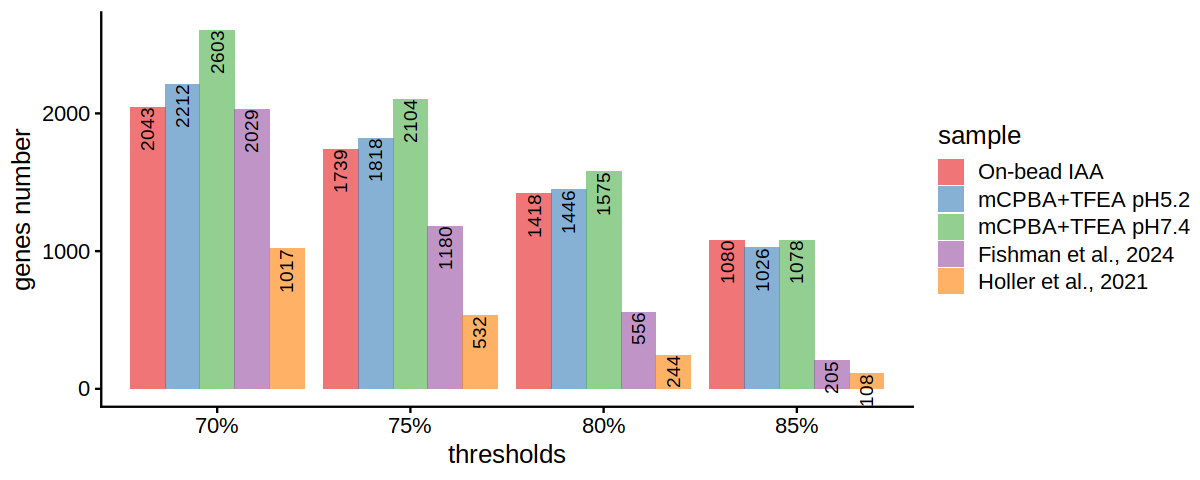

In [35]:
options(repr.plot.width = 10 ,repr.plot.height = 4)
number_p <-ggplot(data = bar_df ,aes(x = thresholds,y = value)) + 
  geom_bar(stat="identity",aes(fill=sample),width=0.9,position='dodge')+
  scale_fill_manual(values = alpha(colorRampPalette(brewer.pal(9,'Set1'))(9)[1:5],0.6))+
  geom_text(data = bar_df
            , aes(label = value, y = value, fill = sample)
            ,position = position_dodge(width =0.9)
            , size = 4,vjust=0.5,angle=90,hjust=1) + 
  ylab('genes number')+
  cowplot::theme_cowplot(font_size = 15)
number_p

# Fig3E & FigS4B

In [36]:
order_3 <- c('On-bead IAA','mCPBA+TFEA pH5.2','mCPBA+TFEA pH7.4')

In [37]:
barplot_fun <- function(value,threshold){
    tmp <- all_var_common %>% mutate(classification = case_when(ntr <= 0.05 ~ 'M(ntr<0.05)',
                                                                     ntr >= value ~ threshold,
                                                                     TRUE ~ 'MZ'))
    
    tmp <- subset(tmp,classification %in% c('M(ntr<0.05)','MZ',threshold))
    prop_df_final <- prop.table(table(tmp$sample,tmp$classification),margin = 1) %>% as.data.frame()
    prop_df_final$Var2 <- factor(prop_df_final$Var2,levels = c(threshold,'MZ','M(ntr<0.05)'))
    prop_df_final_3 <- subset(prop_df_final,Var1 %in% order_3)
    options(repr.plot.width = 6 ,repr.plot.height = 5)
    class_number_5.5_final <- ggplot(data =prop_df_final_3 ,aes(x = Var1,y = round(Freq*100,2),fill = Var2,alluvium  = Var2)) + 
       geom_bar(stat = "identity",width = .6,position="stack") + 
       geom_text(aes(label = round(Freq*100,2)), position = position_stack(vjust = 0.5), color = "black",size=4) + 
       geom_flow(alpha = .5) + 
       scale_fill_manual(values=c('#FAE090','#DFE1E3','#AFDDE7')) +
       theme_classic(base_size = 15)+
       labs(y = '% Genes', fill = 'classifacation')+labs(x = NULL)+
       theme(axis.text.x= element_text(colour = 'black',angle = 30,hjust = 1),
            axis.text.y= element_text(colour = 'black'))

    options(repr.plot.width = 8 ,repr.plot.height = 5)
    class_number_final_5 <- ggplot(data = prop_df_final ,aes(x = Var1,y = round(Freq*100,2),fill = Var2,alluvium  = Var2)) + 
       geom_bar(stat = "identity",width = .6,position="stack") + 
       geom_text(aes(label = round(Freq*100,2)), position = position_stack(vjust = 0.5), color = "black",size=4) +  
       geom_flow(alpha = .5) + 
       scale_fill_manual(values=c('#FAE090','#DFE1E3','#AFDDE7')) +
       theme_classic(base_size = 15)+
       labs(y = '% Genes', fill = 'classifacation')+labs(x = NULL)+
       theme(axis.text.x= element_text(colour = 'black',angle = 30,hjust = 1),
            axis.text.y= element_text(colour = 'black'))

    options(repr.plot.width = 8 ,repr.plot.height = 5)
    return(list(class_number_5.5_final,class_number_final_5))
}

In [38]:
bar_70 <- barplot_fun(0.7,"Z(ntr>0.70)")
bar_75 <- barplot_fun(0.75,"Z(ntr>0.75)")
bar_80 <-barplot_fun(0.8,"Z(ntr>0.80)")
bar_85 <-barplot_fun(0.85,"Z(ntr>0.85)")

In [39]:
library(patchwork)

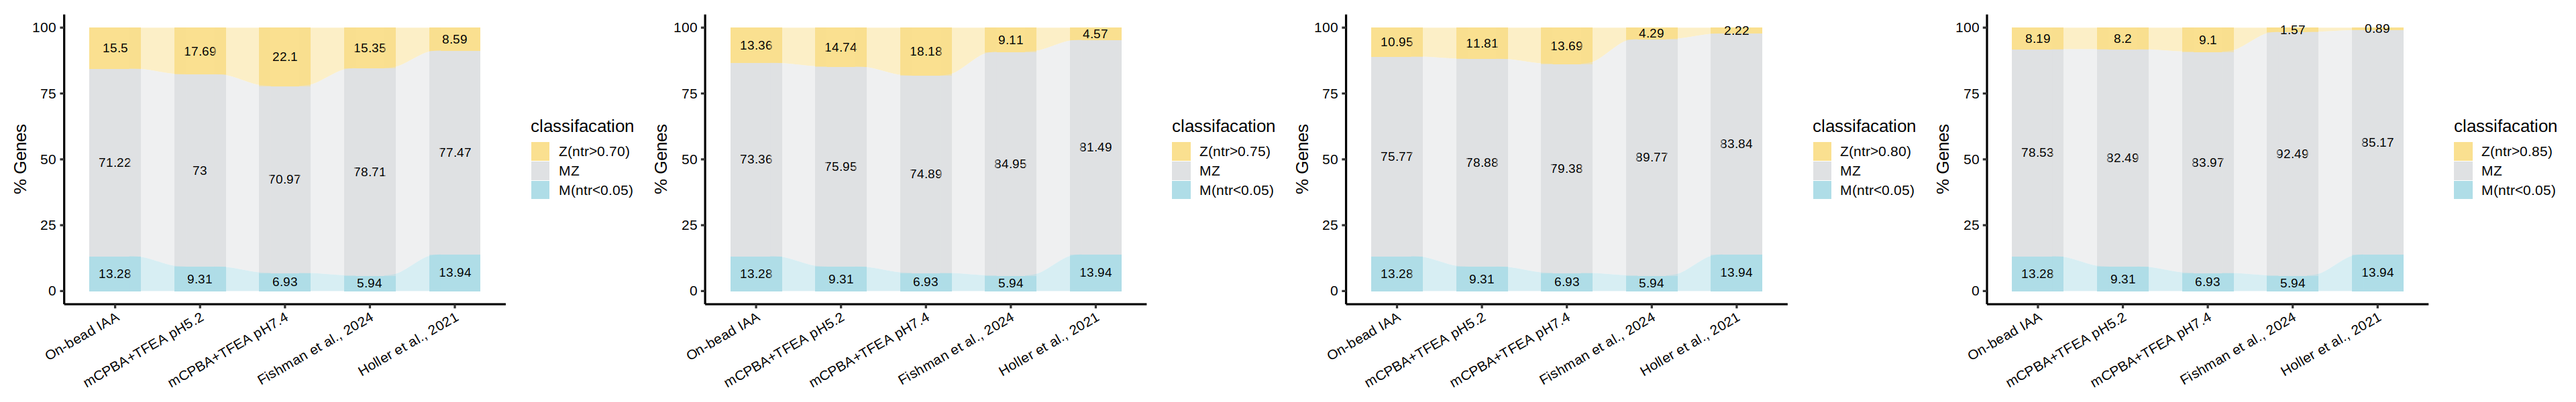

In [40]:
options(repr.plot.width = 32 ,repr.plot.height = 5)
bar_70[[2]] + bar_75[[2]] + bar_80[[2]] + bar_85[[2]] + plot_layout(ncol = 4)

# Fig3F & FigS4C

In [41]:
vennplot_fun <- function(value,threshold){
    tmp <- all_var_common %>% mutate(classification = case_when(ntr <= 0.05 ~ 'M(ntr<0.05)',
                                                                     ntr >= value ~ threshold,
                                                                     TRUE ~ 'MZ'))
    Z_genes <- subset(tmp,classification==threshold)
    venn.gene.list <- split(Z_genes$gene_name,Z_genes$sample)
    venn_5 <- Venn(venn.gene.list)
    venn.data_5 <- process_data(venn_5)

    venn_muban_5 <- ggplot() +
      # change mapping of color filling
      geom_polygon(aes(X, Y, fill = id, group = id), 
              data = venn_regionedge(venn.data_5),fill='gray99',
              show.legend = FALSE) +
      # adjust edge size and color
      geom_path(aes(X, Y, color = id, group = id), 
              data = venn_setedge(venn.data_5), 
              linewidth = 1,
              show.legend = FALSE) +
      # show set label in bold
      geom_text(aes(X, Y, label = name), 
                fontface = "bold",
                data = venn_setlabel(venn.data_5)) +
      # add a alternative region name
      geom_label(aes(X, Y, label = count), 
                 data = venn_regionlabel(venn.data_5),
                 alpha = 0.5,label.size = NA) +
      coord_equal() +
    #  scale_fill_manual(values = colorRampPalette((pal_npg("nrc")(10)))(31))+
      scale_color_manual(values = alpha(colorRampPalette(brewer.pal(9,'Set1'))(9)[1:5],0.6))+
      theme_void()
    venn_muban_5

    venn_3 <- Venn(venn.gene.list[c(1:3)])
    venn.data_3 <- process_data(venn_3)

    venn_muban_3 <- ggplot() +

      geom_polygon(aes(X, Y, fill = id, group = id), 
              data = venn_regionedge(venn.data_3),fill='gray99',
              show.legend = FALSE) +

      geom_path(aes(X, Y, color = id, group = id), 
              data = venn_setedge(venn.data_3), 
              linewidth = 1,
              show.legend = FALSE) +

      geom_text(aes(X, Y, label = name), 
                fontface = "bold",
                data = venn_setlabel(venn.data_3)) +

      geom_label(aes(X, Y, label = count), 
                 data = venn_regionlabel(venn.data_3),
                 alpha = 0.5,label.size = NA) +
      coord_equal() +

      scale_color_manual(values = alpha(colorRampPalette(brewer.pal(9,'Set1'))(9)[1:3],0.6))+
      theme_void()
    options(repr.plot.height = 10, repr.plot.width = 10)
    return(list(venn_muban_3,venn_muban_5))
    }

In [42]:
venn_70 <-vennplot_fun(0.7,"Z(ntr>0.70)")
venn_75 <-vennplot_fun(0.75,"Z(ntr>0.75)")
venn_80 <-vennplot_fun(0.8,"Z(ntr>0.80)")
venn_85 <-vennplot_fun(0.85,"Z(ntr>0.85)")

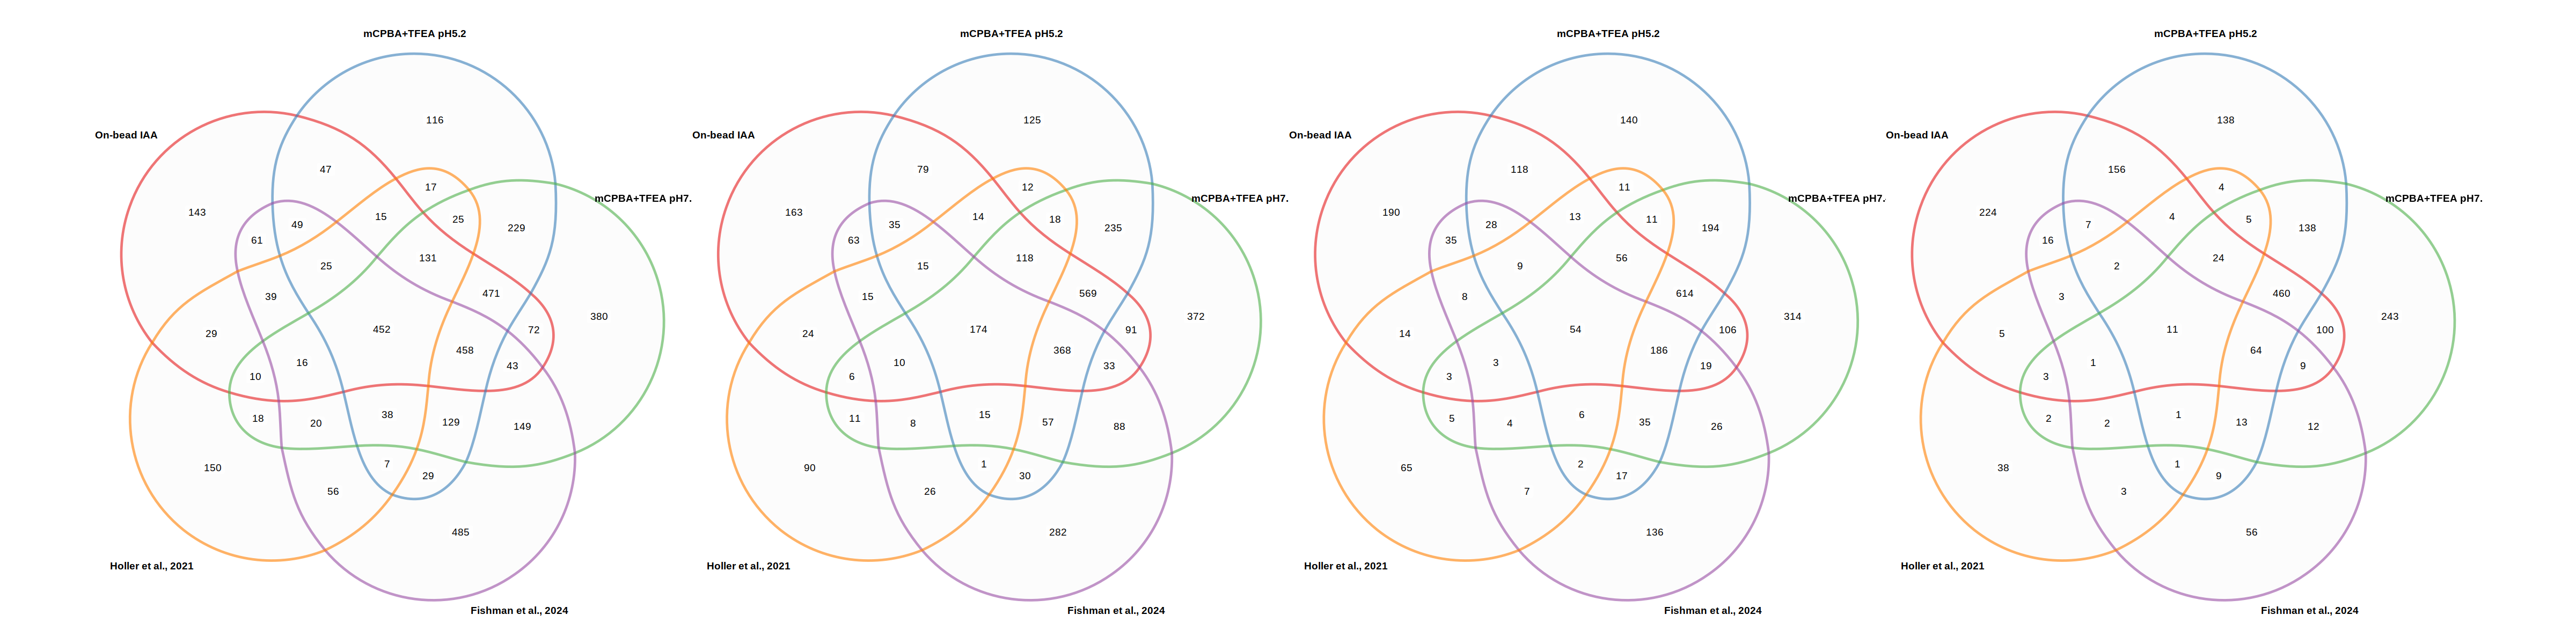

In [ ]:
options(repr.plot.width = 40 ,repr.plot.height = 10)
venn_70[[2]]+venn_75[[2]]+venn_80[[2]]+venn_85[[2]]+ plot_layout(ncol = 4)

# FigS4 A

In [44]:
bins_cut <- function(df,braek) {

  df$bin <- cut(df$ntr,
                breaks = quantile(df$ntr, probs = braek),
                include.lowest = TRUE,
                labels = FALSE)

  df <- df %>%
    group_by(bin) %>%
    mutate(min_ntr = min(ntr),
           max_ntr = max(ntr)) %>%
    ungroup() %>%
    mutate(range = paste0(format(round(min_ntr, 2)*100, nsmall = 0), "-", format(round(max_ntr, 2)*100, nsmall = 0),'%')) %>%
    select(-min_ntr, -max_ntr)

  return(df)
}

In [45]:
table(all_var_common$sample)
head(all_var_common,2)


         On-bead IAA     mCPBA+TFEA pH5.2     mCPBA+TFEA pH7.4 
               13298                12652                11951 
Fishman et al., 2024  Holler et al., 2021 
               13391                12201 

gene_name,mt,n_cells,nCells,nCounts,pass_basic_filter,log_m,score,log_cv,frac,use_for_pca,ntr,sample
<chr>,<lgl>,<int>,<int>,<int>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>,<fct>
AL590149.1,FALSE,24,24,24,FALSE,NA,NA,NA,1.882293e-06,FALSE,0.4583333,On-bead IAA
AL590150.2,FALSE,72,72,78,TRUE,-4.886274,-0.1006419,2.588405,5.435317e-06,FALSE,0.7948718,On-bead IAA


In [46]:
df_iaa <- subset(all_var_common,sample =='On-bead IAA')
df_m5 <- subset(all_var_common,sample =='mCPBA+TFEA pH5.2')
df_m7 <- subset(all_var_common,sample =='mCPBA+TFEA pH7.4')

In [47]:
list_df <- list(df_iaa = df_iaa, df_m5 = df_m5, df_m7 = df_m7)


range_list_df <- lapply(list_df, function(df) {

  df$bin <- cut(df$ntr,
                breaks = quantile(df$ntr, probs = seq(0, 1, by = 0.1)),
                include.lowest = TRUE,
                labels = FALSE)

  df <- df %>%
    group_by(bin) %>%
    mutate(min_ntr = min(ntr),
           max_ntr = max(ntr)) %>%
    ungroup() %>%
    mutate(range = paste0(format(round(min_ntr, 2)*100, nsmall = 0), "-", format(round(max_ntr, 2)*100, nsmall = 0),'%')) %>%
    select(-min_ntr, -max_ntr)

  return(df)
})


In [48]:
range_3df <- bind_rows(range_list_df)
table(range_3df$sample)


         On-bead IAA     mCPBA+TFEA pH5.2     mCPBA+TFEA pH7.4 
               13298                12652                11951 
Fishman et al., 2024  Holler et al., 2021 
                   0                    0 

Warning message:
“Duplicated aesthetics after name standardisation: fill”
Warning message:
“Duplicated aesthetics after name standardisation: fill”
Warning message:
“Duplicated aesthetics after name standardisation: fill”


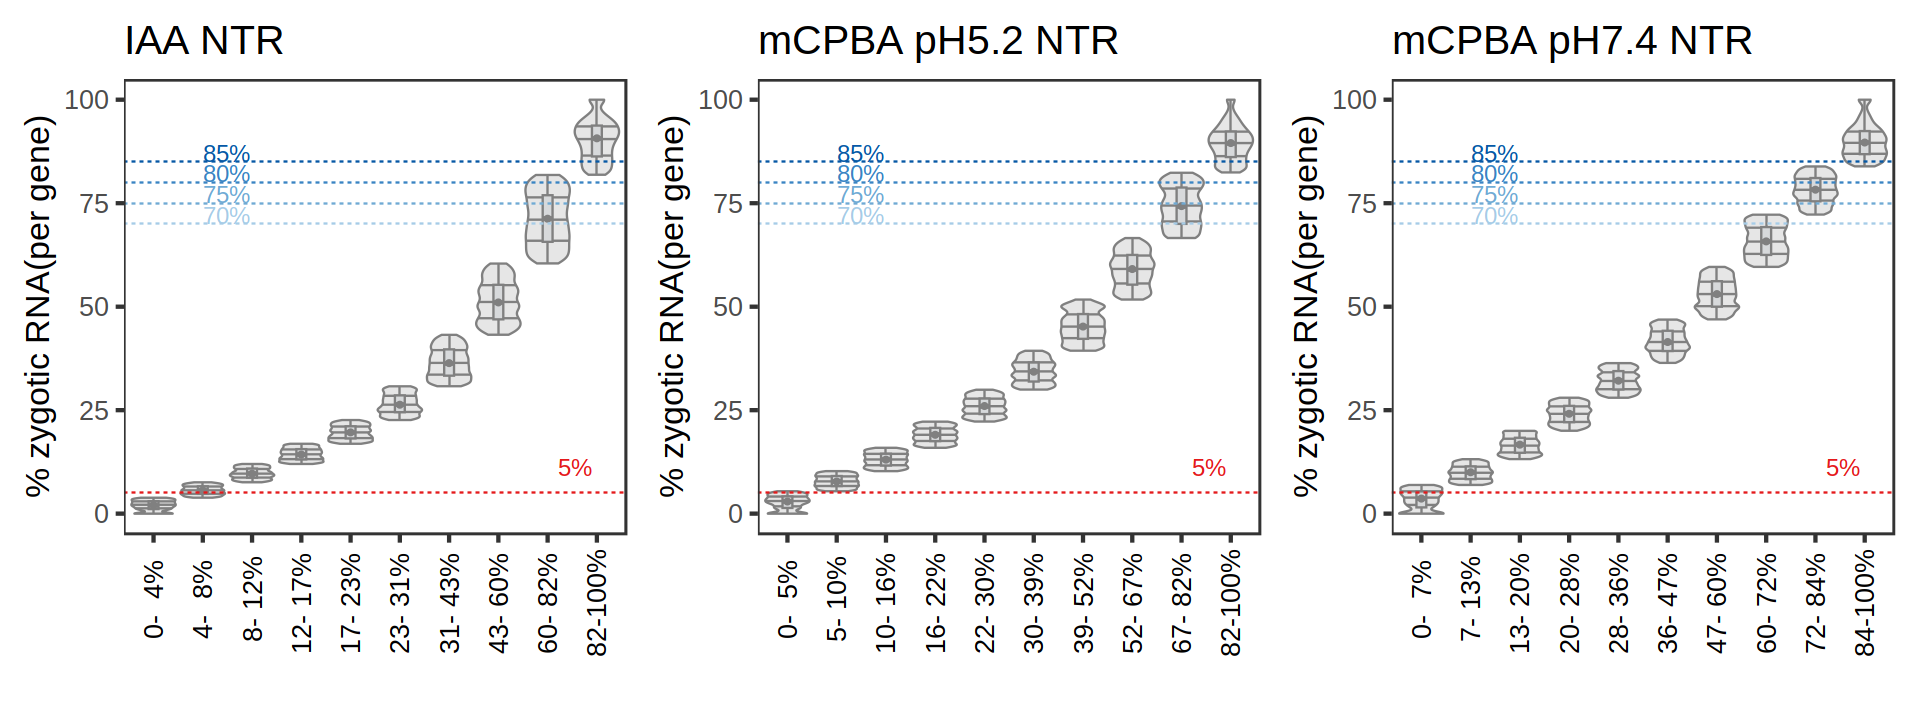

In [49]:
iaa_range <- ggplot(data = range_list_df$df_iaa,mapping = aes(x=range,y=ntr*100))+
  geom_violin(fill= '#E6E6E6',trim = TRUE,draw_quantiles = c(0.25, 0.5, 0.75),scale = "width",fill='#D7D9DB',col='#808080')+
  geom_boxplot(width = 0.2,fill='#D7D9DB',col='#808080',outlier.shape = NA) +
  #添加median点
  stat_summary(fun.y="median",geom="point",shape=20, size=2,fill='#D7D9DB',col='#808080')+
  ylab("% zygotic RNA(per gene)") +
  xlab(" ") +
theme_bw(base_size = 20)+
  theme(axis.text.x = element_text(colour = 'black',angle=90,vjust = 0.5),panel.grid = element_blank(),
                                  legend.position = 'none')+
  geom_hline(yintercept = c(5,70,75,80,85),linetype ='dashed',colour=c("#E41A1C","#A6CCE7","#6FAAD4","#3984C3","#0658A5"))+
  annotate("text", x = Inf, y = 5, label = "5%", vjust = -1, hjust = 2, size = 5, colour = "#E41A1C") +
  annotate("text", x = Inf, y = 70, label = "70%", vjust = 0, hjust = 9, size = 5, colour = "#A6CCE7") +
  annotate("text", x = Inf, y = 75, label = "75%", vjust = 0, hjust = 9, size = 5, colour = "#6FAAD4") +
  annotate("text", x = Inf, y = 80, label = "80%", vjust = 0, hjust = 9, size = 5, colour = "#3984C3") +
  annotate("text", x = Inf, y = 85, label = "85%", vjust = 0, hjust = 9, size = 5, colour = "#0658A5") 

m5_range <- ggplot(data = range_list_df$df_m5,mapping = aes(x=range,y=ntr*100))+
  geom_violin(fill= '#E6E6E6',trim = TRUE,draw_quantiles = c(0.25, 0.5, 0.75),scale = "width",fill='#D7D9DB',col='#808080')+
  geom_boxplot(width = 0.2,fill='#D7D9DB',col='#808080',outlier.shape = NA) +

  stat_summary(fun.y="median",geom="point",shape=20, size=2,fill='#D7D9DB',col='#808080')+
  ylab("% zygotic RNA(per gene)") +
  xlab(" ") +
theme_bw(base_size = 20)+
  theme(axis.text.x = element_text(colour = 'black',angle=90,vjust = 0.5),panel.grid = element_blank(),
                                  legend.position = 'none')+
  geom_hline(yintercept = c(5,70,75,80,85),linetype ='dashed',colour=c("#E41A1C","#A6CCE7","#6FAAD4","#3984C3","#0658A5"))+
  annotate("text", x = Inf, y = 5, label = "5%", vjust = -1, hjust = 2, size = 5, colour = "#E41A1C") +
  annotate("text", x = Inf, y = 70, label = "70%", vjust = 0, hjust = 9, size = 5, colour = "#A6CCE7") +
  annotate("text", x = Inf, y = 75, label = "75%", vjust = 0, hjust = 9, size = 5, colour = "#6FAAD4") +
  annotate("text", x = Inf, y = 80, label = "80%", vjust = 0, hjust = 9, size = 5, colour = "#3984C3") +
  annotate("text", x = Inf, y = 85, label = "85%", vjust = 0, hjust = 9, size = 5, colour = "#0658A5") 

m7_range <- ggplot(data = range_list_df$df_m7,mapping = aes(x=range,y=ntr*100))+
  geom_violin(fill= '#E6E6E6',trim = TRUE,draw_quantiles = c(0.25, 0.5, 0.75),scale = "width",fill='#D7D9DB',col='#808080')+
  geom_boxplot(width = 0.2,fill='#D7D9DB',col='#808080',outlier.shape = NA) +

  stat_summary(fun.y="median",geom="point",shape=20, size=2,,fill='#D7D9DB',col='#808080')+
  ylab("% zygotic RNA(per gene)") +
  xlab(" ") +
theme_bw(base_size = 20)+
  theme(axis.text.x = element_text(colour = 'black',angle=90,vjust = 0.5),panel.grid = element_blank(),
                                  legend.position = 'none')+
  geom_hline(yintercept = c(5,70,75,80,85),linetype ='dashed',colour=c("#E41A1C","#A6CCE7","#6FAAD4","#3984C3","#0658A5"))+
  annotate("text", x = Inf, y = 5, label = "5%", vjust = -1, hjust = 2, size = 5, colour = "#E41A1C") +
  annotate("text", x = Inf, y = 70, label = "70%", vjust = 0, hjust = 9, size = 5, colour = "#A6CCE7") +
  annotate("text", x = Inf, y = 75, label = "75%", vjust = 0, hjust = 9, size = 5, colour = "#6FAAD4") +
  annotate("text", x = Inf, y = 80, label = "80%", vjust = 0, hjust = 9, size = 5, colour = "#3984C3") +
  annotate("text", x = Inf, y = 85, label = "85%", vjust = 0, hjust = 9, size = 5, colour = "#0658A5") 

library(patchwork)


iaa_range <- iaa_range + ggtitle("IAA NTR")
m5_range <- m5_range + ggtitle("mCPBA pH5.2 NTR")
m7_range <- m7_range + ggtitle("mCPBA pH7.4 NTR")
options(repr.plot.height =6, repr.plot.width = 16)

merge_NTR_plot <- (iaa_range / m5_range / m7_range) +
  plot_layout(ncol = 3)
merge_NTR_plot

# FigS4D

In [61]:
rate_all <- qs::qread('/home/mingjian/workbase/04_chemical.methods/07.code_submit/data/Fig4_data/FigS4D_data.rds')

In [62]:
table(rate_all$sample)


       5.5hpf-Dropseq-IAA 5.5hpf-Dropseq-mCPBApH5.2 5.5hpf-Dropseq-mCPBApH7.4 
                    20532                     35436                     43848 
        5.3hpf-IAA-2024NC     6hpf-insituIAA-2021NC 
                    43776                     73464 

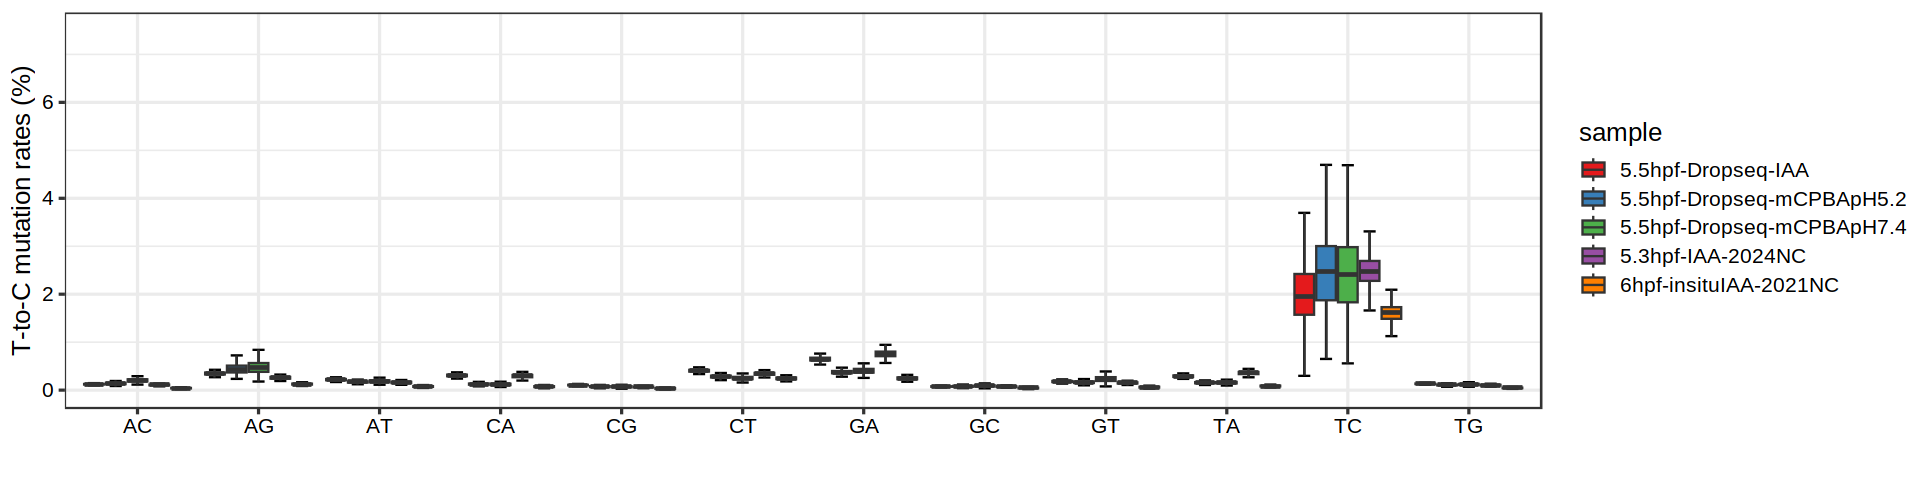

In [63]:
options(repr.plot.height=4,repr.plot.width=16)
allbase_plot_5 <- ggplot(rate_all, aes(variable, value*100, fill = sample)) +
  stat_boxplot(geom = "errorbar",width = 0.5,colour='black',position = position_dodge(0.9)) + 
  geom_boxplot(width = 0.9,outlier.shape = NA) +
  ylab("T-to-C mutation rates (%)") +
  xlab(" ") +
  scale_fill_manual(values = colorRampPalette(brewer.pal(9,'Set1'))(9)) +
  scale_colour_manual(values = colorRampPalette(brewer.pal(9,'Set1'))(9))+
  coord_cartesian(ylim = c(0,7.5))+
  theme_bw(base_size = 15)+
    theme(
        axis.text.x = element_text(colour = 'black'), 
        axis.text.y = element_text(colour = 'black') 
    )
allbase_plot_5